<h1>Новые скважины

**Описание проекта:**

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

**Цель проекта:**

Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые)
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки
- Бюджет на разработку скважин в регионе — 10 млрд рублей
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью

**Этапы проекта**

1. [Обзор данных](#1)
2. [Подготовка данных](#2)
3. [Подготовка к расчёту прибыли](#3)
4. [Расчёт прибыли по выбранным скважинам и предсказаниям модели](#4)
5. [Риски и прибыль](#5)
6. [Выводы](#6)

<a id='1'></a>

<h2> Обзор данных

Импортируем необходимые библиотеки для будущей работы. Считаем данные из csv-файлов, сохраним в переменные и изучим их.

Пути к файлам: 

- `/datasets/geo_data_0.csv`
- `/datasets/geo_data_1.csv`
- `/datasets/geo_data_2.csv`

In [1]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# импорты модулей текущего проекта
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# настройки
warnings.filterwarnings('ignore')

#константа
RANDOM_STATE = np.random.RandomState(12345)

In [2]:
# константы для задачи
POINTS = 500  # всего точек для исследования
BEST_POINTS = 200  # всего лучших точек
BUDGET = 10e9  # бюджет на разработку скважин, млрд.руб
UNIT_BARREL = 450e3  # доход с единицы продукта, тыс.руб

In [3]:
try:
    df1 = pd.read_csv('C:\jupyter projects\geo_data_0.csv')
    df2 = pd.read_csv('C:\jupyter projects\geo_data_1.csv')
    df3 = pd.read_csv('C:\jupyter projects\geo_data_2.csv')
    sns.set_style('darkgrid')
except:
    df1 = pd.read_csv('/datasets/geo_data_0.csv')
    df2 = pd.read_csv('/datasets/geo_data_1.csv')
    df3 = pd.read_csv('/datasets/geo_data_2.csv')
    sns.set_style('darkgrid')

In [4]:
names = ['Регион 1', 'Регион 2', 'Регион 3']
colors = {'Регион 1':'#A18594', 'Регион 2':'#FFB28B', 'Регион 3':'#AFCBFF'}


# функция для вывода информации о данных
def df_info(df, name):
    print(f'\033[1m{name}\033[0m')
    display(df.head())
    print('_' * 60, '\n')
    print(f'\nДлина датасета: {len(df)} \nРазмер датасета: {df.shape}')
    print('Количество явных дубликатов:', df.duplicated().sum())
    print('Количество неявных дубликатов по id:', df['id'].duplicated(keep=False).sum())
    print('Количество пропущенных значений:\n', df.isna().sum(), '\n')
    display(df.info())
    print('_' * 60, '\n')
    display(df.describe())
    print('_' * 60, '\n')
    display(df.corr().style.background_gradient(cmap='coolwarm'))
    fig, ax = plt.subplots(2 , 2, figsize=(10,6))
    df.hist(figsize=(12,7), layout=(2,2), color=colors[name], bins=20, ax=ax)
    plt.suptitle(name)

Регион 1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


____________________________________________________________ 


Длина датасета: 100000 
Размер датасета: (100000, 5)
Количество явных дубликатов: 0
Количество неявных дубликатов по id: 20
Количество пропущенных значений:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

____________________________________________________________ 



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


____________________________________________________________ 



,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


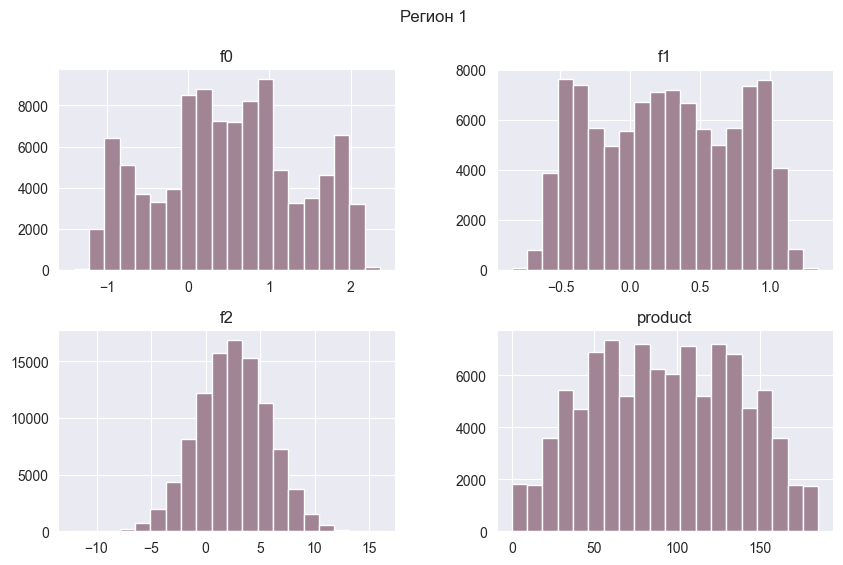

In [5]:
df_info(df1, names[0])

Регион 2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


____________________________________________________________ 


Длина датасета: 100000 
Размер датасета: (100000, 5)
Количество явных дубликатов: 0
Количество неявных дубликатов по id: 8
Количество пропущенных значений:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

____________________________________________________________ 



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


____________________________________________________________ 



,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


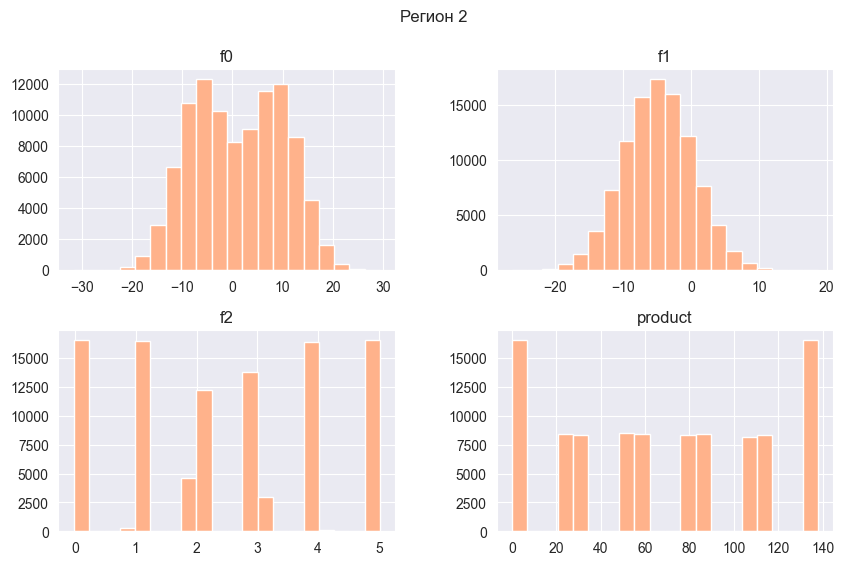

In [6]:
df_info(df2, names[1])

Регион 3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


____________________________________________________________ 


Длина датасета: 100000 
Размер датасета: (100000, 5)
Количество явных дубликатов: 0
Количество неявных дубликатов по id: 8
Количество пропущенных значений:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

____________________________________________________________ 



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


____________________________________________________________ 



,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


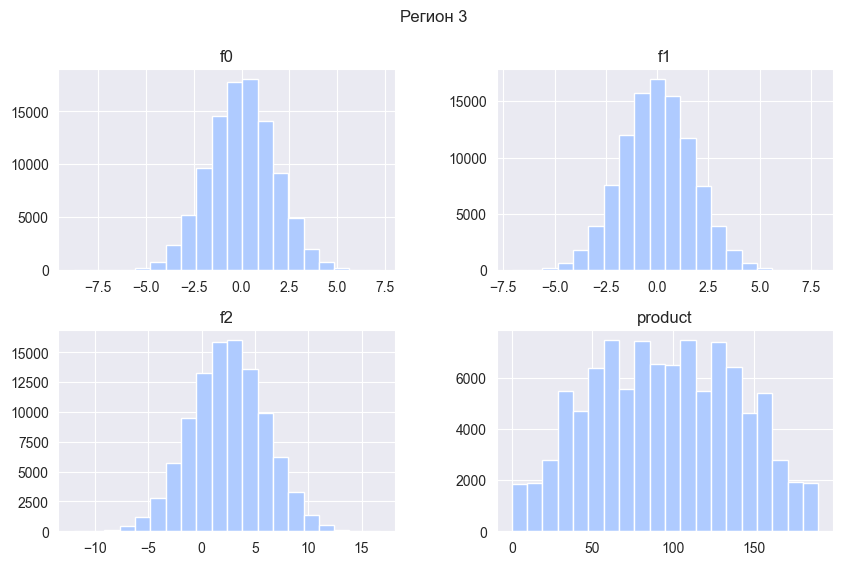

In [7]:
df_info(df3, names[2])

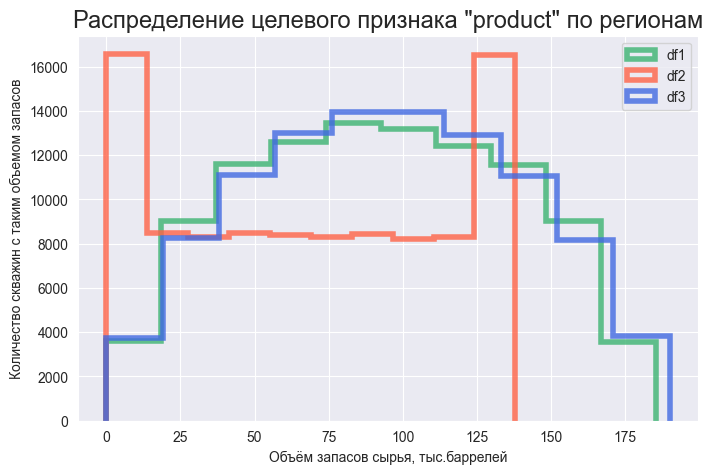

In [8]:
plt.figure(figsize=(8,5))
plt.title('Распределение целевого признака "product" по регионам', fontsize=17)
plt.xlabel('Объём запасов сырья, тыс.баррелей')
plt.ylabel('Количество скважин с таким объемом запасов')
df1['product'].hist(color='mediumseagreen', label="df1", alpha=0.8, histtype='step', linewidth=4)
df2['product'].hist(color='tomato', label="df2", alpha=0.8, histtype='step', linewidth=4)
df3['product'].hist(color='royalblue', label="df3", alpha=0.8, histtype='step', linewidth=4)
plt.legend();

<h3>Вывод

- Длина всех датасетов: 100000 
- Размер всех датасетов: (100000, 5)
- Явные дубликаты отсутствуют
- Присутствуют дубликаты строк по столбцу `id`: 20 в первом датасете и по 8 в других
- Пропуски отсутствуют
- Проблема мультиколлинеарности отсутствует
- Заметна высокая зависимость между целевым признаком `product` и предиктором `f2` в каждом из датасетов, особенно высоко это значений в датасете второго региона - значение близко к единице
- Большой разброс значений стандартного отклонения у признаков `f0`, `f1` и `f2`
- Целевой признак задачи - `product`. Распредление его значений для первого и третьего регионов схожи, тогда как второй сильно выделяется своими пиками

<a id='2'></a>

<h2> Подготовка данных

Посмотрим на строки с дублирующимся `id`.

In [9]:
data = [df1, df2, df3]

for df in data:
    display(df[df['id'].duplicated(keep=False)].head(10))

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Видно, что все значения признаков у дубликатов отличаются. Мы не можем выявить какие из строк содержат истинные значения, поэтому удалим дубликаты по `id`, которые встречаются после первой записи.

In [10]:
# в drop_duplicates() по умолчанию keep=first
for df in data:
    df = df.drop_duplicates(subset='id', inplace=True)

Проверим.

In [11]:
for df in data:
    print('Дубликаты в df1:', df['id'].duplicated(keep=False).sum(),'\n')

Дубликаты в df1: 0 

Дубликаты в df1: 0 

Дубликаты в df1: 0 



In [12]:
df1.shape, df2.shape, df3.shape

((99990, 5), (99996, 5), (99996, 5))

Удалим столбец `id` в каждом датасете, так как он не несёт никакой полезной информации и будет только мешать обучению модели.

In [13]:
# удаление айдишника
df1 = df1.drop(['id'], axis=1)
df2 = df2.drop(['id'], axis=1)
df3 = df3.drop(['id'], axis=1)

data = [df1, df2, df3]

# проверка
for i in range(3):
    display(data[i].head())

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


Создадим функцию, которая будет выполнять следующие действия для каждого датасета:

- Разобъет данные на обучающую и валидационную выборки в соотношении 75:25.

- Стандартизирует данные

- Обучит модель и сделает предсказания на валидационной выборке

- Сохранит предсказания на валидационной выборке и правильные ответы в словарь

- Напечатает на экране средний запас фактического сырья, предсказанного сырья и `RMSE` модели

In [14]:
# список с именами и словарь для правильных ответов и предсказаний
names = ['df1', 'df2', 'df3']
names_2 = {'df1':'в первом регионе', 'df2':'во втором регионе', 'df3':'в третьем регионе'}
names_3 = ['в первом регионе', 'во втором регионе', 'в третьем регионе']

In [15]:
# словарь для правильных ответов и предсказаний, словарь для подсчетов
targets = {}
metrics = {}

# функция разбиеня на выборки
def ml_df(df, name):
    
    # переменные с признками и целевым признаком
    features = df.drop('product', axis=1)
    target = df['product']
        
    # разделение на выборки
    (features_train, features_valid, 
    target_train, target_valid) = train_test_split(features,
                                                   target,
                                                   test_size=.25,
                                                   random_state=RANDOM_STATE)
    
    print(f'Размерность тренировочной выборки для {name}:{target_train.shape[0]/target.shape[0]:.0%}')
    print(f'Размерность валидационной выборки для {name}:{target_valid.shape[0]/target.shape[0]:.0%}')
    
    # пайплайн 
    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    # добавление значений в словарь
    targets[name] = (target_valid, pd.Series(predictions, index=target_valid.index, name='product_predicted'))
    
    # подсчеты среднего значения и rmse
    fact_mean = targets[name][0].mean()
    preds_mean = targets[name][1].mean()
    rmse = sqrt(mean_squared_error(targets[name][0], targets[name][1]))
    
    # добавение подсчетов в словарь
    metrics[name] = {'Фактический средний запас':fact_mean, 'Предсказанный средний запас':preds_mean, 'RMSE':rmse}
    print('_' * 60, '\n')

In [16]:
# применяем функцию ко всем датасетам
for i in range(3):
    ml_df(data[i], names[i])
    
# преобразуем словарь в таблицу
pd.DataFrame.from_dict(metrics)

Размерность тренировочной выборки для df1:75%
Размерность валидационной выборки для df1:25%
____________________________________________________________ 

Размерность тренировочной выборки для df2:75%
Размерность валидационной выборки для df2:25%
____________________________________________________________ 

Размерность тренировочной выборки для df3:75%
Размерность валидационной выборки для df3:25%
____________________________________________________________ 



,df1,df2,df3
Фактический средний запас,92.158205,68.970382,95.517364
Предсказанный средний запас,92.789156,68.957466,95.079497
RMSE,37.853527,0.894780,40.041557


<h3>Вывод


По итогам обработки, мы:

- Удалили признак `id`
- Стандартизировали данные
- Разбили данные на тренировочную и валидационную выборки
- Нашли средний запас предсказанного сырья и вывели `RMSE` модели
- Выяснили, что лучший показатель `RMSE` у `df2` - 0.89, тогда как у других датасетов показатели `RMSE` довольно высокие - 37.8 и 40, что указывает на невысокую точность модели.

<a id='3'></a>

<h2> Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [17]:
lossfree_value = BUDGET/(BEST_POINTS*UNIT_BARREL)
print(f'Достаточный объем нефти в скважине, требуемый для безубыточной \
разработки: {lossfree_value:.1f} тыс. баррелей')

Достаточный объем нефти в скважине, требуемый для безубыточной разработки: 111.1 тыс. баррелей


Сравним полученный объём сырья со средним запасом в каждом регионе.

In [18]:
# средний запас сырья по регионам
def mean_value(df,name):
    mean_value = df['product'].mean()
    print(f'Средний запас сырья {names_2[name]}: {mean_value:.1f} тыс. баррелей')
    print(f'Процент скважин с объемом сырья больше, чем пороговое значение: \
{len(df.query("product>@lossfree_value"))/len(df):.2%}\n')

In [19]:
for i in range(3):
    mean_value(data[i], names[i])

Средний запас сырья в первом регионе: 92.5 тыс. баррелей
Процент скважин с объемом сырья больше, чем пороговое значение: 36.58%

Средний запас сырья во втором регионе: 68.8 тыс. баррелей
Процент скважин с объемом сырья больше, чем пороговое значение: 16.54%

Средний запас сырья в третьем регионе: 95.0 тыс. баррелей
Процент скважин с объемом сырья больше, чем пороговое значение: 38.18%



<h3>Вывод

Объем нефти в скважине, требуемый для безубыточной разработки, равен 111.1 тыс. баррелей. 

Среднее значение запасов в регионах находится в диапазоне от 68.8 до 95 тыс. баррелей, а процент скважин с запасами сырья выше пороговой величины в 111.1 тыс.барелей в регионах не превышает 40%.

Чтобы понять, какой из регионов сможет окупиться, применим технику `bootstrap` - сгенерируем 1000 подвыборок с помощью семплирования с возвращением. Случайным образом отберем точки, выделим из них 200 с лучшими предскзаниями сырья и, посчитав финансовый результат работы в них, оценим прибыль и риски работы в регионе.

<a id='4'></a>

<h2> Расчёт прибыли по выбранным скважинам и предсказаниям модели

Расчитаем прибыль по скважинам с максимальным запасом. 

Напишем функцию, которая:

- Выберет скважины с максимальными значениями предсказаний

- Просуммирует целевое значение объёма сырья, соответствующее этим предсказаниям

- Рассчитает прибыль для полученного объёма сырья

In [20]:
products = []
revenues = []
def profit(target, probs):
    predict_sorted = probs.sort_values(ascending=False)[:BEST_POINTS]
    selected = target[predict_sorted.index]
    product = selected.sum()    
    products.append(product)
    revenue = (product*UNIT_BARREL)-BUDGET
    revenues.append(revenue)
    return revenue

In [21]:
for i in range(3):
    for name in names:
        profit(targets[name][0], targets[name][1])
    print(f'Суммарный запас сырья в 200 лучших скважинах \
{names_3[i]} составит: {products[i]:.1f} тыс.баррелей')
    print(f'Средняя прибыль с 200 лучших скважин {names_3[i]} \
для полученного сырья: {revenues[i]/10e8:.2f} млрд. рублей\n')

Суммарный запас сырья в 200 лучших скважинах в первом регионе составит: 29700.4 тыс.баррелей
Средняя прибыль с 200 лучших скважин в первом регионе для полученного сырья: 3.37 млрд. рублей

Суммарный запас сырья в 200 лучших скважинах во втором регионе составит: 27589.1 тыс.баррелей
Средняя прибыль с 200 лучших скважин во втором регионе для полученного сырья: 2.42 млрд. рублей

Суммарный запас сырья в 200 лучших скважинах в третьем регионе составит: 27684.7 тыс.баррелей
Средняя прибыль с 200 лучших скважин в третьем регионе для полученного сырья: 2.46 млрд. рублей



<h3>Вывод

Сделав расчёты мы узнали, что скважины с максимальным значением предсказаний в каждом регионе потенциально прибыльный. Самым перспективным выглядит первый регион.

<a id='5'></a>

<h2>Риски и прибыль

Найдем распределение прибыли, применив технику Bootstrap с 1000 выборками. Также выведем значения средней прибыли, 95%-й доверительный интервал и риск убытков.

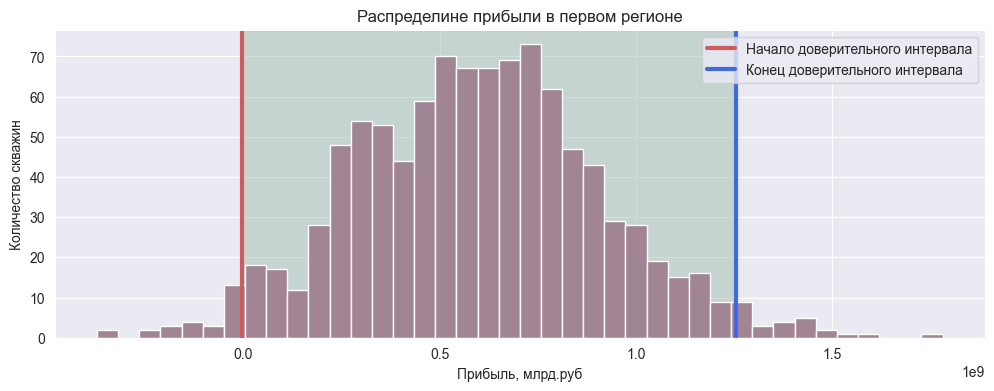

Средняя прибыль: 598 млн. руб.
95%-й доверительный интервал от -4 млн. руб. до 1255 млн. руб.
Процент риска убытков: 2.6%


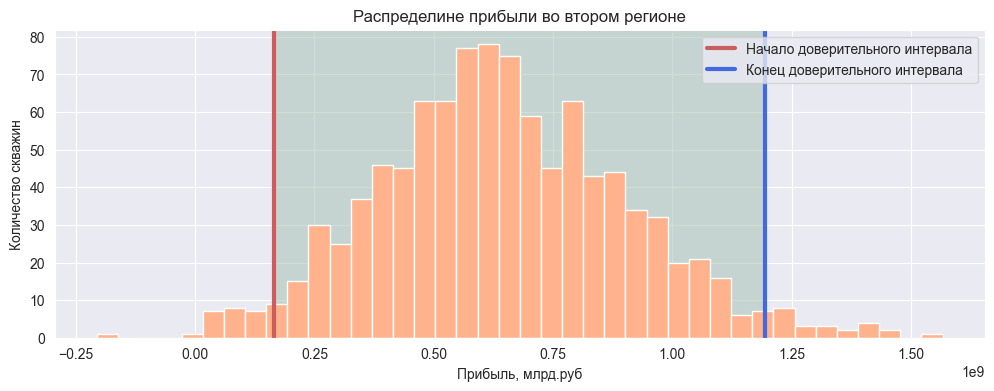

Средняя прибыль: 645 млн. руб.
95%-й доверительный интервал от 164 млн. руб. до 1193 млн. руб.
Процент риска убытков: 0.2%


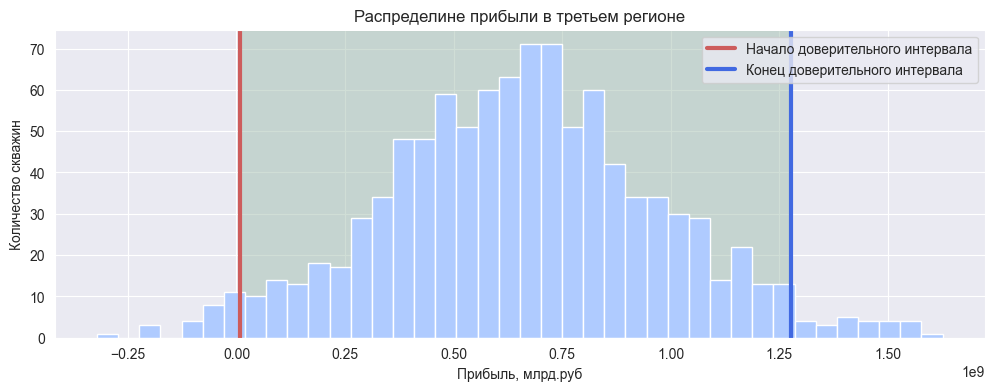

Средняя прибыль: 659 млн. руб.
95%-й доверительный интервал от 9 млн. руб. до 1278 млн. руб.
Процент риска убытков: 1.9%


In [22]:
colors = {'df1':'#A18594', 'df2':'#FFB28B', 'df3':'#AFCBFF'}

for name in names:
    values = []
    # bootstrap
    for i in range(1000):
        valid_subsample = targets[name][0].sample(POINTS, 
                                                  replace=True, 
                                                  random_state=RANDOM_STATE)
        predicts_subsample = targets[name][1][valid_subsample.index]
        values.append(profit(valid_subsample, predicts_subsample))
    #расчеты    
    values = pd.Series(values)    
    mean = values.mean()/10e5
    lower = values.quantile(0.025)/10e5
    upper = values.quantile(0.975)/10e5
    # график
    plt.axvspan(values.quantile(.025), values.quantile(.975), color='#A2BFAF', alpha=0.5)
    values.hist(figsize=(12,4), color=colors[name], bins=40)
    plt.axvline(values.quantile(.025), 
                color='indianred', 
                linewidth=3)
    plt.axvline(values.quantile(.975), 
                color='royalblue', 
                linewidth=3)
    plt.legend(['Начало доверительного интервала', 
                'Конец доверительного интервала'])
    plt.title(f'Распределине прибыли {names_2[name]}')
    plt.xlabel('Прибыль, млрд.руб')
    plt.ylabel('Количество скважин')
    plt.show()
    # значения
    print(f'Средняя прибыль: {mean:.0f} млн. руб.')
    print(f'95%-й доверительный интервал от {lower:.0f} млн. руб. \
до {upper:.0f} млн. руб.')
    print(f'Процент риска убытков: {(values < 0).mean():.1%}')

<h3> Вывод

Лучше всего себя показывает второй регион со средней прибылью в 645 млн.рублей и почти нулевым(0.2%) риском убытков. Его доверительный интервал - от 164 млн. руб. до 1193 млн. руб. 

Также стоит обратить внимание на третий регоин с процентом  риска убытков в 1.9% и средней прибылью в 659 млн.рублей.

<a id='6'></a>

<h2> Выводы

<h3> Цель проекта

Найти и предложить наиболее выгодные по прибыли и риску регионы для разработки скважин.

<h3> Исходные данные

**Признаки**
- `id` — уникальный идентификатор скважины
- `f0, f1, f2` — три признака точек

**Целевой признак**
- `product` — объём запасов в скважине (тыс. баррелей)

<h3> Выводы

Перед работой с данными мы изучили содержание и распределение в каждом из датасетов, выявив следующее:
- Дубликаты отсутствуют
- Пропуски отсутствуют
- Присутствует проблема мультиколлинеарности
- Большой разброс значений стандартного отклонения у признаков f0, f1 и f2
- Распредление значений `product` для первого и третьего регионов схожи, тогда как для второго оно сильно отличается

---

При подготовке данных мы:
- Удалили столбец `id` в каждом датасете
- Создали тренировочную и валидационную выборки в соотношении 75:25
- Обучили модель `LinearRegression()` на тренировочной выборке, сделали предсказания на валидационной выборке и сохранили их в словарь вместе с правильными ответами
- Посчитали предсказанный средний запас сырья, фактический средний запас сырья и `RMSE`модели
- Выявили, что `RMSE` выдает довольно высокие значения для df1 и df3

---

В ходе решения задачи мы:
- Установили средний объем нефти в скважине, требуемый для безубыточной разработки: 111.1 тыс. баррелей
- Сравнили средний запас нефти в регионах с пороговым значением для безубыточной работы
- Выбрали скважины с максимальными значениями предсказаний, рассчитали прибыль по ним и предсказаниям модели. Увидели, что разработка выбранных скважин в каждом регионе прибыльна
- Применив технику `bootstrap`, вычислили распределение прибли. Нашли среднюю прибыль, 95%-й доверительный квартал и риск убытков для каждого региона
- Лучше всего себя показывают второй регион со средней прибылью в 645 млн.рублей и почти нулевым(0.2%) риском убытков и третий регион со средней прибылью 659 млн. рублей и процентом риска убытков в 1.9%.

---

Рекомендации бизнесу:

*На основе проведенной работы, можно порекомендовать компании «ГлавРосГосНефть» выбрать ***второй и третий регионы*** для бурения новой скважины, так как данные локации являетсю самыми потенциально прибыльными и окупаемыми - процент риска убытков ниже 2.5% и средняя прибыль составляет 645 и 659 млн.руб. соответственно*

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту.

Демьян, проект получился на довольно хорошем уровне - отличная работа над проектом, молодец!

Мне нравится твой аналитический подход к выполнению проекта, ты соблюдаешь структуру работы, выполняешь её последовательно - это очень хорошо! Шаги проекта выполнены по порядку согласно плану проекта, нет смысловых и структурных ям. Важно, что не забываешь про выводы.
    
Отмечу отличный уровень аналитики данных в проекте: при знакомстве с данными были рассмотрены все ключевые моменты, на которые стоит обращать внимание при работе с линйной моделью. Положительно также отмечу автоматизацию повтояющихся операций, а также корректный процесс оценки прибыли и рисков техникой бутстрапа - молодец, что не запутался в этом непростом процессе.
    
Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.
    
Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)
    
Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.
    
Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)
    
Жду твой проект на повторном ревью. До встречи:)

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
  
Привет! 
    
Большое спасибо за фидбэк. Все оставленные тобой моменты поправил и отметил это комментарием.
    </div>

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту v.2.

Демьян, все замечания учтены - проект принят!
    
Спасибо за хорошую работу над проектом, желаю успехов в дальнейшем обучении:)